# Installation 
#### Anaconda 3-4.2.0 (or higher)
#### Create virtual environment >> conda create -n yourenvname
#### Activate virtual environment >>  conda activate yourenvname
#### Install torchvision (Installs pytorch too) >> conda install -c pytorch torchvision
#### Open Jupyter notebook >> jupyter notebook

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import cv2 as cv
from statistics import mode
# from skimage import io

## TO-DO LIST

1. Make test and train sets 
    - image folders and label csvs
    - make transform
    - invoke customDataset to make test n train sets



2. Set CNN parameters


# Class convention

0 - Forward
1 - Backward
2 - Stop
3 - Background

## Input Transformation
#### Convert the Numpy arrays to PyTorch tensors and normalize input

In [2]:
kernel_size = (51,51)
GaussianSigma = 40

def rgbEqualize(img):
    img_yuv = cv.cvtColor(img, cv.COLOR_BGR2YUV)

    # equalize the histogram of the Y channel
    img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])

    # convert the YUV image back to RGB format
    img_output = cv.cvtColor(img_yuv, cv.COLOR_YUV2BGR)
    
    return img_output
    



In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

## Loading dataset
#### This is a built-in demo. Creating your own custom dataloader is discussed later

In [4]:
class liveDataset(Dataset):
    
    def __init__(self, images, transform=None):
        self.data = images
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data[index].values.astype(np.uint8).reshape((3,50,50))
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, None
    

In [5]:
class kagDataset(Dataset):
    
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # load image as ndarray type (Height * Width * Channels)
        # be carefull for converting dtype to np.uint8 [Unsigned integer (0 to 255)]
        # in this example, i don't use ToTensor() method of torchvision.transforms
        # so you can convert numpy ndarray shape to tensor in PyTorch (H, W, C) --> (C, H, W)
        image = self.data.iloc[index, 1:].values.astype(np.uint8).reshape((3,50,50))
        label = self.data.iloc[index, 0]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    
    

In [6]:
# trainset = datasets.MNIST('~/Documents/Sem9/TA-COL780/Pytorch_tutorial/', download=True, train=True, transform=transform)
# testset = datasets.MNIST('~/Documents/Sem9/TA-COL780/Pytorch_tutorial/', download=True, train=False, transform=transform)

train_path = './data/train/train.csv'
test_path = './data/test/test.csv'



trainset = kagDataset(train_path)
testset = kagDataset(test_path)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=20, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=20, shuffle=True)
classes = ('0','1','2','3')

In [7]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([20, 3, 50, 50])
torch.Size([20])


In [8]:
# plt.imshow(images[0].numpy().squeeze());  

In [9]:
# figure = plt.figure()
# num_of_images = 15
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Constructing the network

In [10]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 11 * 11, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
# print(net)

In [11]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1936, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training the network

[1,    20] loss: 1.443
[1,    40] loss: 0.577
[1,    60] loss: 0.332
[2,    20] loss: 0.131
[2,    40] loss: 0.065
[2,    60] loss: 0.075
Finished Training


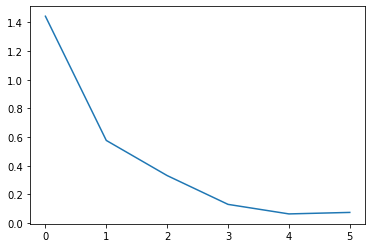

In [13]:
mini_batch = 20
loss_values = []
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # make the parameter gradients zero
        optimizer.zero_grad()

        # forward + backward + optimize
        inputs=inputs.float()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % mini_batch == mini_batch-1:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / mini_batch))
            loss_values.append(running_loss/mini_batch)
            running_loss = 0.0
        
plt.plot(loss_values)

print('Finished Training')

In [14]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


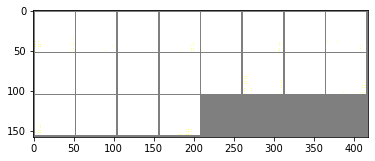

    0     1     3     1


In [15]:
# get some training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


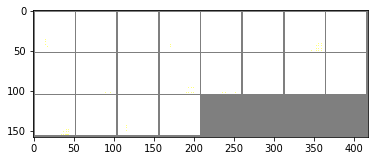

GroundTruth:      0     2     3     0


In [16]:
# get some test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
# print labels
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


## Checking Train and Test accuracies

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images = images.float()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 99 %


In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.float()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 52 %


In [30]:
vid = cv.VideoCapture(0)

print("Video dimensions are: %d x %d " %(int(vid.get(3)), int(vid.get(4))))

backSubMOG = cv.bgsegm.createBackgroundSubtractorMOG()

input_data = []

Video dimensions are: 1280 x 720 


In [31]:
frame_width=1920
frame_height=1080
font = cv.FONT_HERSHEY_SIMPLEX

while True:
    ret, frame = vid.read()
    if ret==True:
#         gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
        subbedFrameMOG = backSubMOG.apply(frame)
        
        
#         cv.imshow('MOG', subbedFrameMOG)


#         frame = cv.resize(gray, (50,50), interpolation = cv.INTER_AREA)
    
      
        frame = rgbEqualize(frame)
        
        blur_frame = cv.GaussianBlur(frame, kernel_size, GaussianSigma)
        blur_frame = cv.resize(blur_frame, (50,50), interpolation = cv.INTER_AREA)

        
        
        blur_displayFrame = cv.resize(blur_frame, (600,600), interpolation = cv.INTER_AREA)
        blur_displayFrame = blur_displayFrame[:, ::-1]
        
#         cv.imshow('original_blur', blur_displayFrame)




        input_data.append(blur_frame.flatten().tolist())
        finalLabel = -1

        if len(input_data) == 20:
            testset = liveDataset(input_data)
            test_loader = torch.utils.data.DataLoader(testset, batch_size=20, shuffle=False)
           
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, _ = data
                    images = images.float()
                    outputs = net(images)
                    
                    try:
                        _, predicted = torch.max(outputs.data, 1)
#                         print(predicted)

                        labelCount = np.array([0,0,0,0])
                        for i in predicted:
                            labelCount[predicted[i]]+=1

                        finalLabel = np.argmax(labelCount)
                    except:
                        finalLabel = 4
#                     print(finalLabel)
            blur_displayFrame = cv.putText(blur_displayFrame, str(finalLabel), (200,200), font, 3, (0,255,0),10,cv.LINE_AA)
            input_data = []
            cv.imshow('original_blur', blur_displayFrame)


        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
        
vid.release()
cv.destroyAllWindows()
cv.waitKey(1)



-1

## Making your own custom Dataloader

In [18]:
class customDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.label.iloc[idx, 0])
#         print(img_name)
        image = cv.imread(img_name)
        labels = self.label.iloc[idx, 1]
        labels = np.array([labels])
        labels = labels.astype('float').reshape(-1, 1)
        sample = {'image': image, 'label': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [19]:
# custom_dataset = customDataset(csv_file='labels.csv',
#                                     root_dir='/home/surya/Documents/Sem9/TA-COL780/Pytorch_tutorial/images/')

# for i in range(len(custom_dataset)):
#     sample = custom_dataset[i]

#     print(i, sample['image'].shape, sample['label'].shape, sample['label'][0][0])
